In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
import json
import ast


In [2]:
df = pd.read_csv('MatDX_EF.csv')
df

,formula,space_group,structure,id,formation_energy
0,Ni4Ta6,R-3c,"[{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3...",PN_MCKVEQNTJFRUHOURCR2HCEB35KDFRETL,{'reference': {'Ni': 'https://nomad-lab.eu/pro...
1,Mn4Sb2,I4_1/amd,"[{'data': {'a': [-1.87778212e-10, 1.87604249e-...",PN_FGGHB2NFWUCYD3YZO4FWN3QVOKCTVI6K,{'reference': {'Mn': 'https://nomad-lab.eu/pro...
2,Ir2Na2,Imma,"[{'data': {'a': [-1.36776653e-10, 2.60817299e-...",PN_BAO7ZSBZZCMA7PH7QMR7WLDI72GOELND,{'reference': {'Na': 'https://nomad-lab.eu/pro...
3,MoSm,R-3m,"[{'data': {'a': [1.65820251e-10, 9.57363439999...",PN_4YR2JLVZHJLC3F2TYPTOVDBJJ52C6XIE,{'reference': {'Mo': 'https://nomad-lab.eu/pro...
4,Sn17P12,I-43m,"[{'data': {'a': [-5.563178910000001e-10, 5.563...",PN_H6P36AVAKDU244QNQGGCJ7YLC4A4F2YE,{'reference': {'P': 'https://nomad-lab.eu/prod...
...,...,...,...,...,...
4995,Ag3Br,P4/mmm,"[{'data': {'a': [3.54083755e-10, 0, 0], 'b': [...",PN_GGP4J67ICWQHYNTSDBZQJFBJKFHKP2TY,{'reference': {'Br': 'https://nomad-lab.eu/pro...
4996,Al16Ge8,Fd-3m,"[{'data': {'a': [0, 6.01749067e-10, 6.01749067...",PN_HZ6TO4YLVA2K7PWWHZJRSFEAYOZLE3WF,{'reference': {'Al': 'https://nomad-lab.eu/pro...
4997,Pt2Th2,Cmcm,"[{'data': {'a': [-3.93770842e-10, 0, 0], 'b': ...",PN_5CPW22CGT4NOR6246BCGTZUO2UMDXXWI,{'reference': {'Th': 'https://nomad-lab.eu/pro...
4998,Ga5Sr,Cmmm,"[{'data': {'a': [2.2508728800000003e-10, -6.32...",PN_Y33JSPVMM6O4AYYYNR2LHUUT5WFVXJJC,{'reference': {'Ga': 'https://nomad-lab.eu/pro...


In [12]:
unique_elements = set()
for formula in df['formula']:
    # Extract elements based on uppercase letters followed by lowercase letters or numbers
    elements = [part for part in formula if part.isalpha()]
    unique_elements.update(elements)

# Count unique elements and unique space groups
num_unique_elements = len(unique_elements)
num_unique_space_groups = df['space_group'].nunique()

num_unique_formula = df['formula'].nunique()

num_unique_elements, num_unique_space_groups, num_unique_formula

(35, 78, 3282)

In [13]:
# Sample code to identify how many examples in 'df' have the same 'formula' but different 'space_group'

# Group by 'formula' and check unique 'space_group' counts for each group
duplicates_with_different_space_group = df.groupby('formula')['space_group'].nunique()

# Filter to find cases where there is more than one unique 'space_group' for the same 'formula'
duplicates_count = (duplicates_with_different_space_group > 1).sum()

duplicates_count


np.int64(687)

In [23]:
duplicates_with_different_space_group = df.groupby('formula')['space_group'].nunique()

# Filter for formulas with more than one unique 'space_group'
duplicates = duplicates_with_different_space_group[duplicates_with_different_space_group > 1]

# Display each formula and the count of unique space groups
# for formula, unique_count in duplicates.items():
#     print(f"Formula: {formula}, Unique Space Groups: {unique_count}")

len(duplicates)

687

In [27]:
# Count occurrences of each (formula, space_group) pair to find exact duplicates
duplicate_pairs = df.groupby(['formula', 'space_group']).size()

# Filter for pairs that occur more than once
exact_duplicates = duplicate_pairs[duplicate_pairs > 1]

# Display the result
exact_duplicates_df = exact_duplicates.reset_index(name='count')
exact_duplicates_df


,formula,space_group,count
0,Ac4Br6,R-3c,2
1,Ac4I6,R-3c,2
2,AcAl3,I4/mmm,2
3,AcMn,P4/mmm,2
4,Ag2Al,I4/mmm,2
...,...,...,...
651,WBr,Cmmm,2
652,WP3,Fm-3m,2
653,WSb,Pm-3m,4
654,YbBr,Fm-3m,2


In [36]:
df = df.reset_index().rename(columns={'index': 'original_index'})

# Count occurrences of each (formula, space_group) pair to find exact duplicates
duplicate_pairs = df.groupby(['formula', 'space_group']).size()
exact_duplicates = duplicate_pairs[duplicate_pairs > 1].reset_index(name='count')

# Filter the original DataFrame to include only exact duplicate pairs and keep original indices
duplicate_df = df.merge(exact_duplicates[['formula', 'space_group']], on=['formula', 'space_group'])


duplicate_df['formation_energy'] = duplicate_df['formation_energy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract 'value' from the 'formation_energy' dictionary
duplicate_df['formation_energy_value'] = duplicate_df['formation_energy'].apply(lambda x: x.get('value') if isinstance(x, dict) else None)

# Group by 'formula' and 'space_group' to count unique 'formation_energy_value'
value_consistency = duplicate_df.groupby(['formula', 'space_group'])['formation_energy_value'].nunique()
different_values_df = value_consistency[value_consistency > 1].reset_index(name='unique_value_count')

# Count datapoints for each (formula, space_group) in duplicate_df and include original indices
datapoint_counts = duplicate_df.groupby(['formula', 'space_group']).agg({'original_index': list, 'formation_energy_value': 'size'}).reset_index()
datapoint_counts = datapoint_counts.rename(columns={'formation_energy_value': 'datapoint_count'})

# Merge with the unique_value_count to show the count of unique formation energy values per pair
merged_counts = datapoint_counts.merge(different_values_df, on=['formula', 'space_group'], how='left').fillna(0)
merged_counts['unique_value_count'] = merged_counts['unique_value_count'].astype(int)

# Display the final result
merged_counts

,formula,space_group,original_index,datapoint_count,unique_value_count
0,Ac4Br6,R-3c,"[585, 3834]",2,2
1,Ac4I6,R-3c,"[14, 1021]",2,2
2,AcAl3,I4/mmm,"[1840, 1967]",2,2
3,AcMn,P4/mmm,"[82, 255]",2,2
4,Ag2Al,I4/mmm,"[572, 1002]",2,2
...,...,...,...,...,...
651,WBr,Cmmm,"[3046, 4520]",2,2
652,WP3,Fm-3m,"[1934, 2060]",2,2
653,WSb,Pm-3m,"[244, 1098, 2117, 2460]",4,4
654,YbBr,Fm-3m,"[3119, 3129]",2,2


In [3]:
# Reset index to keep track of original indices
df = df.reset_index().rename(columns={'index': 'original_index'})

# Count occurrences of each (formula, space_group) pair to find exact duplicates
duplicate_pairs = df.groupby(['formula', 'space_group']).size()
exact_duplicates = duplicate_pairs[duplicate_pairs > 1].reset_index(name='count')

# Filter the original DataFrame to include only exact duplicate pairs and keep original indices
duplicate_df = df.merge(exact_duplicates[['formula', 'space_group']], on=['formula', 'space_group'])

# Convert 'formation_energy' from string to dictionary if needed
duplicate_df['formation_energy'] = duplicate_df['formation_energy'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract 'value' and 'value_per_atom' from the 'formation_energy' dictionary
duplicate_df['formation_energy_value'] = duplicate_df['formation_energy'].apply(lambda x: x.get('value') if isinstance(x, dict) else None)
duplicate_df['formation_energy_value_per_atom'] = duplicate_df['formation_energy'].apply(lambda x: x.get('value_per_atom') if isinstance(x, dict) else None)

# Convert extracted columns to numeric, forcing non-numeric values to NaN
duplicate_df['formation_energy_value'] = pd.to_numeric(duplicate_df['formation_energy_value'], errors='coerce')
duplicate_df['formation_energy_value_per_atom'] = pd.to_numeric(duplicate_df['formation_energy_value_per_atom'], errors='coerce')

# Check if conversion was successful
print("Data types after conversion:")
print(duplicate_df[['formation_energy_value', 'formation_energy_value_per_atom']].dtypes)
print("\nAny NaN values in 'formation_energy_value':", duplicate_df['formation_energy_value'].isna().any())
print("Any NaN values in 'formation_energy_value_per_atom':", duplicate_df['formation_energy_value_per_atom'].isna().any())

# Now proceed with aggregation, assuming data types are now clean
stats = duplicate_df.groupby(['formula', 'space_group']).agg(
    unique_value_count=('formation_energy_value', 'nunique'),
    datapoint_count=('formation_energy_value', 'size'),
    formation_energy_mean=('formation_energy_value', 'mean'),
    formation_energy_std=('formation_energy_value', 'std'),
    formation_energy_per_atom_mean=('formation_energy_value_per_atom', 'mean'),
    formation_energy_per_atom_std=('formation_energy_value_per_atom', 'std'),
    original_indices=('original_index', list)
).reset_index()

# Display the final result
stats

Data types after conversion:
formation_energy_value             float64
formation_energy_value_per_atom    float64
dtype: object

Any NaN values in 'formation_energy_value': False
Any NaN values in 'formation_energy_value_per_atom': False


,formula,space_group,unique_value_count,datapoint_count,formation_energy_mean,formation_energy_std,formation_energy_per_atom_mean,formation_energy_per_atom_std,original_indices
0,Ac4Br6,R-3c,2,2,-14.694957,0.102140,-1.469496,0.010214,"[585, 3834]"
1,Ac4I6,R-3c,2,2,-11.355718,0.142808,-1.135572,0.014281,"[14, 1021]"
2,AcAl3,I4/mmm,2,2,-0.090564,0.008318,-0.022641,0.002079,"[1840, 1967]"
3,AcMn,P4/mmm,2,2,0.760808,0.090197,0.380404,0.045098,"[82, 255]"
4,Ag2Al,I4/mmm,2,2,-0.186167,0.000004,-0.062056,0.000001,"[572, 1002]"
...,...,...,...,...,...,...,...,...,...
651,WBr,Cmmm,2,2,2.609098,0.004551,1.304549,0.002276,"[3046, 4520]"
652,WP3,Fm-3m,2,2,1.559718,0.003170,0.389930,0.000792,"[1934, 2060]"
653,WSb,Pm-3m,4,4,1.915868,0.741730,0.638169,0.004431,"[244, 1098, 2117, 2460]"
654,YbBr,Fm-3m,2,2,-2.837811,0.023230,-1.418905,0.011615,"[3119, 3129]"


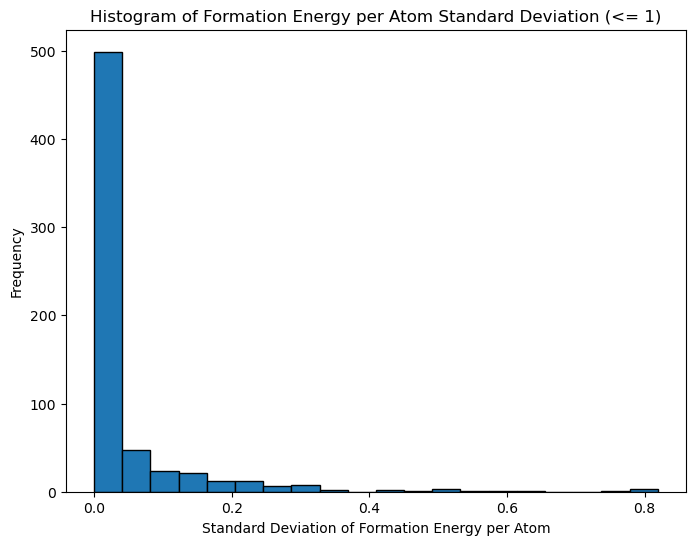

In [15]:
filtered_data = stats[stats['formation_energy_per_atom_std'] <= 1]

# Plotting the histogram of formation_energy_per_atom_std with the filtered data
plt.figure(figsize=(8, 6))
plt.hist(filtered_data['formation_energy_per_atom_std'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Standard Deviation of Formation Energy per Atom')
plt.ylabel('Frequency')
plt.title('Histogram of Formation Energy per Atom Standard Deviation (<= 1)')
plt.show()

In [16]:
# Filter to find rows where 'formation_energy_per_atom_std' is greater than 1
high_std_rows = stats[stats['formation_energy_per_atom_std'] >= 1]

# Display the result
high_std_rows

,formula,space_group,unique_value_count,datapoint_count,formation_energy_mean,formation_energy_std,formation_energy_per_atom_mean,formation_energy_per_atom_std,original_indices
35,Ag5Al3,Amm2,3,3,-4.164328,6.526355,-0.813024,1.322347,"[1193, 1196, 2417]"
153,Ba2Sb,Fmmm,2,2,-12.303201,16.842666,-4.101067,5.614222,"[3350, 3542]"
186,BaIr3,Pm-3m,3,3,10.924861,6.346446,2.731215,1.586612,"[1152, 2606, 2624]"
209,CaPb3,R-3m,2,2,-6.326984,7.867985,-6.040679,8.272880,"[872, 1331]"
253,CsV,P-6m2,3,3,-15.486123,17.871886,-7.743061,8.935943,"[104, 111, 2534]"
320,Fe2Pt2,P4/nmm,3,3,31.126049,53.388937,7.781512,13.347234,"[2061, 2344, 2362]"
329,Fe3Pb,Pm-3m,4,4,4.785100,5.305692,1.196275,1.326423,"[281, 845, 1709, 1745]"
366,Ga13Mn13,R-3m,2,2,70.114182,102.549458,2.696699,3.944210,"[1809, 2373]"
462,MnPt3,R-3m,2,2,-9.573985,12.726548,-9.358376,13.031465,"[406, 2226]"
467,MnW3,Pm-3m,2,2,5.512128,5.499169,1.378032,1.374792,"[1277, 2641]"


In [17]:
for idx in [281, 845, 1709, 1745]:
    print(eval(df['formation_energy'][idx])['value'])
    # print(eval(df['structure'][idx]))

1.547267500665189
3.367298713857238
12.64102251070371
1.5848094332915146


In [10]:
df

,original_index,formula,space_group,structure,id,formation_energy
0,0,Ni4Ta6,R-3c,"[{'data': {'a': [-6.910143e-10, 0, 0], 'b': [3...",PN_MCKVEQNTJFRUHOURCR2HCEB35KDFRETL,{'reference': {'Ni': 'https://nomad-lab.eu/pro...
1,1,Mn4Sb2,I4_1/amd,"[{'data': {'a': [-1.87778212e-10, 1.87604249e-...",PN_FGGHB2NFWUCYD3YZO4FWN3QVOKCTVI6K,{'reference': {'Mn': 'https://nomad-lab.eu/pro...
2,2,Ir2Na2,Imma,"[{'data': {'a': [-1.36776653e-10, 2.60817299e-...",PN_BAO7ZSBZZCMA7PH7QMR7WLDI72GOELND,{'reference': {'Na': 'https://nomad-lab.eu/pro...
3,3,MoSm,R-3m,"[{'data': {'a': [1.65820251e-10, 9.57363439999...",PN_4YR2JLVZHJLC3F2TYPTOVDBJJ52C6XIE,{'reference': {'Mo': 'https://nomad-lab.eu/pro...
4,4,Sn17P12,I-43m,"[{'data': {'a': [-5.563178910000001e-10, 5.563...",PN_H6P36AVAKDU244QNQGGCJ7YLC4A4F2YE,{'reference': {'P': 'https://nomad-lab.eu/prod...
...,...,...,...,...,...,...
4995,4995,Ag3Br,P4/mmm,"[{'data': {'a': [3.54083755e-10, 0, 0], 'b': [...",PN_GGP4J67ICWQHYNTSDBZQJFBJKFHKP2TY,{'reference': {'Br': 'https://nomad-lab.eu/pro...
4996,4996,Al16Ge8,Fd-3m,"[{'data': {'a': [0, 6.01749067e-10, 6.01749067...",PN_HZ6TO4YLVA2K7PWWHZJRSFEAYOZLE3WF,{'reference': {'Al': 'https://nomad-lab.eu/pro...
4997,4997,Pt2Th2,Cmcm,"[{'data': {'a': [-3.93770842e-10, 0, 0], 'b': ...",PN_5CPW22CGT4NOR6246BCGTZUO2UMDXXWI,{'reference': {'Th': 'https://nomad-lab.eu/pro...
4998,4998,Ga5Sr,Cmmm,"[{'data': {'a': [2.2508728800000003e-10, -6.32...",PN_Y33JSPVMM6O4AYYYNR2LHUUT5WFVXJJC,{'reference': {'Ga': 'https://nomad-lab.eu/pro...


In [47]:
dict_1 = eval(df['formation_energy'][585])
dict_2 = eval(df['formation_energy'][3834])

In [49]:
dict_1['value_per_atom'] - dict_2['value_per_atom']

-0.014444765062813003

In [ ]:
# JSON 문자열을 파이썬 딕셔너리로 변환
data = json.loads(data_str.replace("'", "\""))[0]['data']

# CIF 파일 포맷 생성
cif_content = "data_generated_structure\n\n"

# 격자 벡터 정보 추가
cif_content += f"_cell_length_a    {abs(data['a'][0]):.6f}\n"
cif_content += f"_cell_length_b    {abs(data['b'][1]):.6f}\n"
cif_content += f"_cell_length_c    {abs(data['c'][2]):.6f}\n"
cif_content += "_cell_angle_alpha   90.0\n"
cif_content += "_cell_angle_beta    90.0\n"
cif_content += "_cell_angle_gamma   120.0\n\n"

# 격자 정보의 대칭성 정보 (임시로 P1으로 지정)
cif_content += "loop_\n"
cif_content += "_symmetry_equiv_pos_as_xyz\n"
cif_content += "  'x, y, z'\n\n"

# 원자 정보 추가
cif_content += "loop_\n"
cif_content += "_atom_site_label\n"
cif_content += "_atom_site_type_symbol\n"
cif_content += "_atom_site_fract_x\n"
cif_content += "_atom_site_fract_y\n"
cif_content += "_atom_site_fract_z\n"

# 원자 좌표를 CIF에 추가
for atom in data['atoms']:
    element = atom['element']
    x = atom['x'] / abs(data['a'][0])
    y = atom['y'] / abs(data['b'][1])
    z = atom['z'] / abs(data['c'][2])
    cif_content += f"{element} {element} {x:.6f} {y:.6f} {z:.6f}\n"

# 생성된 CIF 내용 출력 또는 파일로 저장
with open("generated_structure.cif", "w") as file:
    file.write(cif_content)

print("CIF file has been created: generated_structure.cif")